# Detection of Vote Fraud

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import math

## Theoretical Benford's law

Benford's law states that in many naturally occurring collections of numbers, the leading digit is likely to be small. In sets that obey Benford's law, in the first position, the number 1 appears as the leading significant digit about 30% of the time, while larger digits occur in that position less frequently: 9 as the first digit less than 5% of the time. Here, a function that compute the theoretical Benford's law is implemented. This function can be used for alle digits (0-9) but for the first position the digit 0 is not allowed.

In [2]:
def benford_nth_digit_probabilities(n):
    """
    Calculate the probabilities for all digits (0-9) appearing at the n-th position.
    For the first position, this is not applicable to digit 0.
    """
    probabilities = {}
    if n == 1:
        probabilities[0] = 0
        for d in range(1, 10):
            probabilities[d] = math.log10(1 + 1 / d)
    else:
        for d in range(10):
            total_sum = 0
            for k in range(10**(n-2), 10**(n-1)):
                total_sum += math.log10(1 + 1 / (10 * k + d))
            probabilities[d] = total_sum
    return probabilities


Now the function is generalized for other bases of numbers.

In [68]:
import math

def benford_nth_digit_probabilities_gen(base=10, n=1):
    """
    Calculate the probabilities for all digits (0 to base-1) appearing at the n-th position
    in a numeric system of the specified base.
    For the first position, this is not applicable to digit 0.
    """
    probabilities = {}
    
    if n == 1:
        # For the first digit, digit 0 is not allowed.
        probabilities[0] = 0
        for d in range(1, base):
            # Use logarithm in the specified base for the calculation
            probabilities[d] = math.log(1 + 1 / d, base)
    else:
        # For subsequent digits, all digits (0 to base-1) are considered
        for d in range(base):
            total_sum = 0
            # Sum over possible positions for digits
            for k in range(base**(n-2), base**(n-1)):
                total_sum += math.log(1 + 1 / (base * k + d), base)
            probabilities[d] = total_sum
    
    return probabilities



In [70]:
# Example usage
base = 10
n = 1
print(benford_nth_digit_probabilities_gen(base, n))


{0: 0, 1: 0.30102999566398114, 2: 0.17609125905568124, 3: 0.1249387366082999, 4: 0.0969100130080564, 5: 0.0791812460476248, 6: 0.06694678963061322, 7: 0.057991946977686726, 8: 0.051152522447381284, 9: 0.04575749056067514}


In [5]:
Benford_theory = pd.DataFrame([benford_nth_digit_probabilities(1), benford_nth_digit_probabilities(2), benford_nth_digit_probabilities(3), benford_nth_digit_probabilities(4)])
Benford_theory = Benford_theory.T
Benford_theory.columns = ['First position', 'Second position', 'Third position', 'Fourth position']

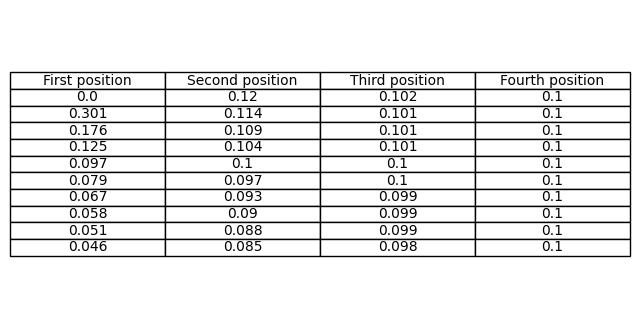

<Figure size 640x480 with 0 Axes>

In [6]:
#only 3 decimal places
Benford_theory = Benford_theory.round(3)

# table to represent the probabilities
fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('tight')
ax.axis('off')
ax.table(cellText=Benford_theory.values, colLabels=Benford_theory.columns, cellLoc='center', loc='center')

plt.show()
plt.savefig('table_with_sum_probabilities.png', dpi=300, bbox_inches='tight')
#write all the data in a type that can be used in a LaTeX table
Benford_theory.to_latex('table_with_sum_probabilities.tex', float_format="%.3f")


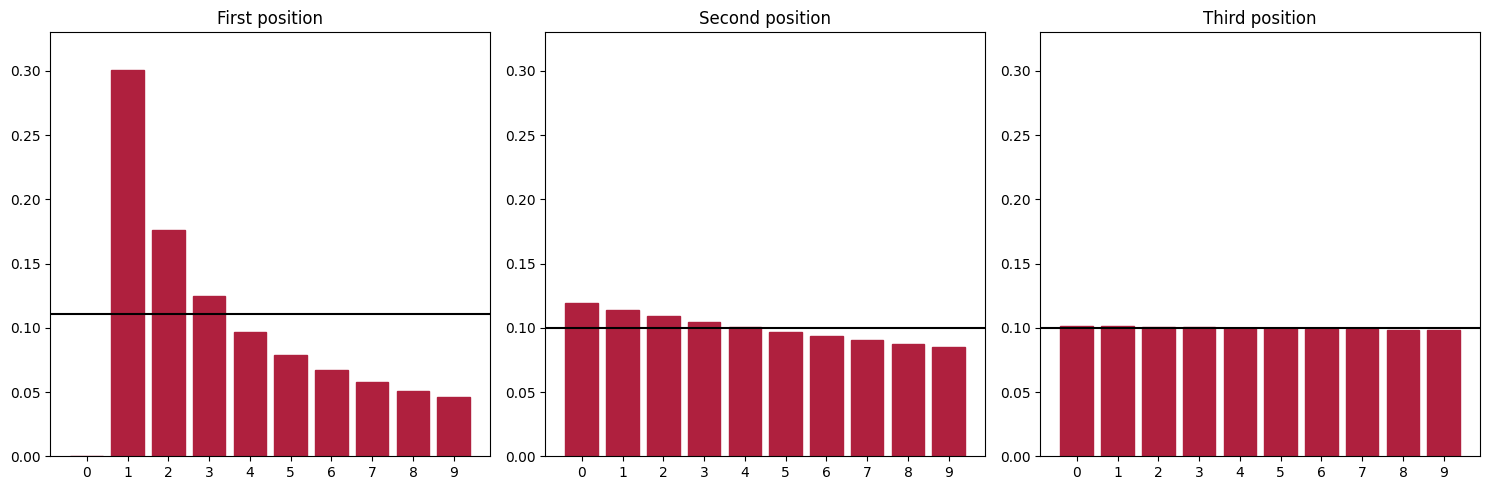

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax in axs:
    ax.set_ylim(0, 0.33)

for ax in axs:
    ax.set_xticks(range(10))

axs[0].bar(benford_nth_digit_probabilities(1).keys(), benford_nth_digit_probabilities(1).values())
axs[0].set_title('First position')
axs[1].bar(benford_nth_digit_probabilities(2).keys(), benford_nth_digit_probabilities(2).values())
axs[1].set_title('Second position')
axs[2].bar(benford_nth_digit_probabilities(3).keys(), benford_nth_digit_probabilities(3).values())
axs[2].set_title('Third position')

#use the color #af203e in HEX for the bars
for ax in axs:
    for bar in ax.patches:
        bar.set_color('#af203e')

for ax in axs:
    if ax.get_title() == 'First position':
        ax.axhline(y=1/9, color='black')
    else:
        ax.axhline(y=1/10, color='black')

plt.tight_layout()
plt.show()



## Application of the Benford's law to the data

In this notebook, a function that computes the probability of the different digits is implemented. The function also take as input the position that the user want to compute the probability. Take care that for the numbers with decimal values, the point is removed. The results are also calcolate for the digits from 0 to 9 but the digit 0 is not allowed in the first position so is 0 everytimes.

In [8]:
def data_digit_probabilities(data, position):
    """
    Calculate the probabilities for the digit (0-9) at a given position according to Benford's Law for a list of numbers.
    Returns a dictionary with digits as keys and their probabilities as values.
    
    Parameters:
        data (list): A list of numerical data (int or float).
        position (int): The position of the digit to analyze (1 for the first digit, 2 for the second, etc.).
    
    Returns:
        probabilities (dict): A dictionary with digit keys (0-9) and their probabilities as values.
    """
    probabilities = {}
    for n in range(0, 10):
        probabilities[n] = 0
    total_count = 0
    
    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= position:
            digit = int(str_number[position - 1])
            probabilities[digit] += 1
            total_count += 1
    
    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(0, 10):
            probabilities[n] /= total_count
    
    return probabilities


In [31]:
def data_digit_probabilities_gen(data, base=10, position=1):
    """
    Calculate the probabilities for the digit (0 to base-1) at a given position according to Benford's Law for a list of numbers.
    Returns a dictionary with digits as keys and their probabilities as values.
    
    Parameters:
        data (list): A list of numerical data (int or float).
        base (int): The base of the numeric system (e.g., 10 for decimal, 16 for hexadecimal).
        position (int): The position of the digit to analyze (1 for the first digit, 2 for the second, etc.).
    
    Returns:
        probabilities (dict): A dictionary with digit keys (0 to base-1) and their probabilities as values.
    """
    probabilities = {n: 0 for n in range(0, base)}
    total_count = 0

    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= position:
            digit = int(str_number[position - 1], base=10)  # Assumes input data is in base 10
            if digit < base:
                probabilities[digit] += 1
                total_count += 1
    
    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(0, base):
            probabilities[n] /= total_count
    
    return probabilities


In [10]:
#use the function above and test it with numbers from 1 to 1000
numbers = list(range(1, 1001))
first_digit_probabilities_for_numbers = data_digit_probabilities(numbers, 2)
first_digit_probabilities_for_numbers


{0: 0.10090817356205853,
 1: 0.09989909182643794,
 2: 0.09989909182643794,
 3: 0.09989909182643794,
 4: 0.09989909182643794,
 5: 0.09989909182643794,
 6: 0.09989909182643794,
 7: 0.09989909182643794,
 8: 0.09989909182643794,
 9: 0.09989909182643794}

A simple function to calculate deviations from Benford's law is here implemented. The deviation is calculated as the difference between the observed frequency and the formula of Benford's law. Delta that results is simply the maximum difference, in percent, between the probbilities of the first significant digit of the given distribution and the Benford's law. Thus, for example, delta=0 means that the distribution is perfectly following Benford's law, delta equal to 15.09 indicates that the probability of some digit d {1,2,3,4,5,6,7,8,9} differs from log10(1+1/d) by 15.09%.

In [11]:
def benford_deviation(observed_probabilities):
    """
    Calculates the deviation from Benford's Law.

    Args:
        observed_probabilities: Dictionary with keys 0 to 9 representing the observed probabilities for each first digit.

    Returns:
        The maximum deviation from Benford's Law, ignoring the key 0 as it does not apply to Benford's Law.
    """
    deviations = []
    for d in range(1, 10):  # Benford's Law applies to digits 1 through 9
        theoretical_probability = math.log10(1 + 1 / d)
        deviation = abs(observed_probabilities[d] - theoretical_probability) * 100
        deviations.append(deviation)

    return max(deviations)


## Application of the function

### Fibonacci sequence

In [12]:
def fibonacci(n):
    a, b = 1, 1
    for _ in range(n):
        yield a
        a, b = b, a + b


In [13]:
fib = list(fibonacci(1000))
fcount=data_digit_probabilities(fib, 1)

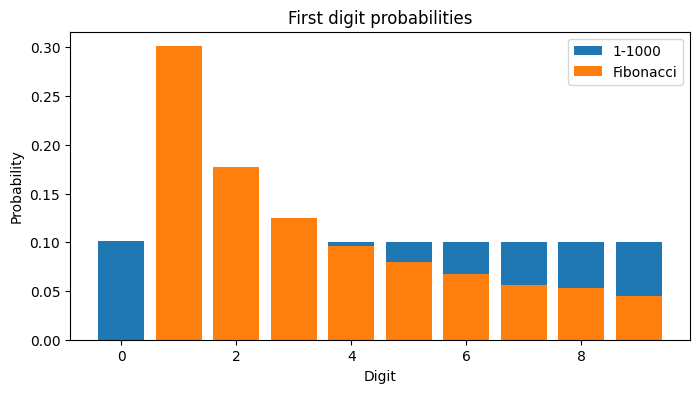

In [14]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(first_digit_probabilities_for_numbers.keys(), first_digit_probabilities_for_numbers.values(), label='1-1000')
ax.bar(fcount.keys(), fcount.values(), label='Fibonacci')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

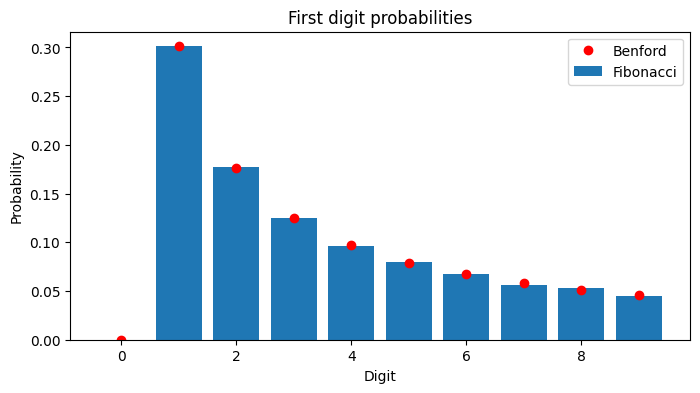

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(fcount.keys(), fcount.values(), label='Fibonacci')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


In [16]:
#create a table with this columns: first digit, Benford's probabilities, Fibonacci's sequence probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities(fib, 1).values()
Benford_theory['Difference'] = Benford_theory['Fibonacci\'s sequence probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Fibonacci's sequence probabilities,Difference
0,0,0.000000,0.000,0.000000
1,1,0.301030,0.301,-0.000030
2,2,0.176091,0.177,0.000909
3,3,0.124939,0.125,0.000061
4,4,0.096910,0.096,-0.000910
5,5,0.079181,0.080,0.000819
6,6,0.066947,0.067,0.000053
7,7,0.057992,0.056,-0.001992
8,8,0.051153,0.053,0.001847
9,9,0.045757,0.045,-0.000757


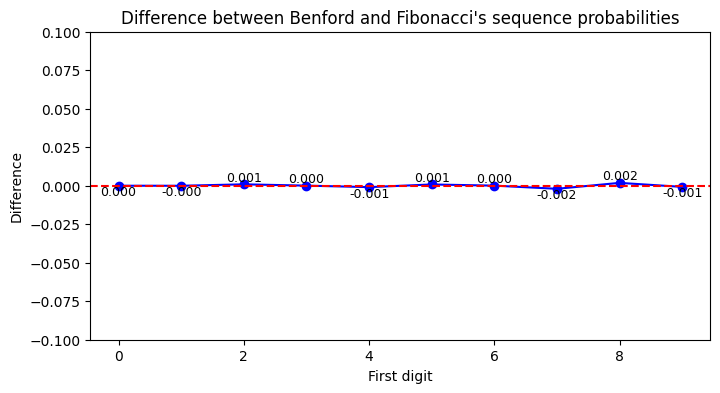

In [17]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Fibonacci\'s sequence probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)
plt.show()


In [18]:
#create a table with this columns: first digit, Benford's probabilities, Election data 2018 probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities_gen(6,1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities_gen(fib, 6,1).values()
Benford_theory['Difference'] = Benford_theory['Fibonacci\'s sequence probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Fibonacci's sequence probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.386853,0.386393,-0.000460
2,2,0.226294,0.227214,0.000920
3,3,0.160558,0.160462,-0.000096
4,4,0.124539,0.123235,-0.001304
5,5,0.101756,0.102696,0.000940


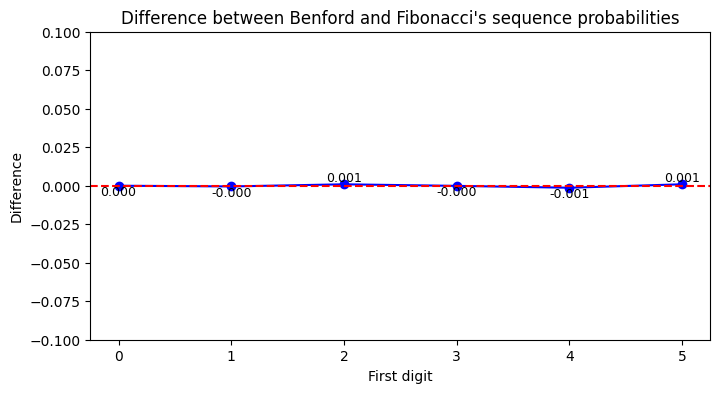

In [19]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Fibonacci\'s sequence probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)
plt.show()


### 2018 Italian elections

#### Data cleaning and preparation

In this cell, we select only the columns that we need for the analysis. We don't have the data for the polling stations so we use the aggregation for comune.

In [20]:
file_path = "C:/Users/franc/Desktop/Tesi/Benford/Codice/Dati/Camera2018_livComune.txt"
election_data_18 = pd.read_csv(file_path, sep=";", encoding='latin1')
election_data_18 = election_data_18[['COMUNE','VOTANTI', 'LISTA', 'COGNOME', 'NOME', 'VOTI_LISTA']]
election_data_18



,COMUNE,VOTANTI,LISTA,COGNOME,NOME,VOTI_LISTA
0,TORINO,124770,CASAPOUND ITALIA,ARNONE,GINO MICHELE DOMENICO,972.0
1,TORINO,124770,IL POPOLO DELLA FAMIGLIA,COLUCCI,VITANTONIO,765.0
2,TORINO,124770,NOI CON L'ITALIA - UDC,FRANCIA,MARCO,743.0
3,TORINO,124770,LEGA,FRANCIA,MARCO,15783.0
4,TORINO,124770,FORZA ITALIA,FRANCIA,MARCO,15055.0
...,...,...,...,...,...,...
133819,VILLENEUVE,705,POUR TOUS PER TUTTI PE TCHEUT,MARCOZ,GIAMPAOLO,NaN
133820,VILLENEUVE,705,FI -FRAT. D'IT. -MOV.NUOVA VALLE D'AOSTA,MELGARA,EDOARDO,NaN
133821,VILLENEUVE,705,RISPOSTA CIVICA,MINELLI,CHIARA,NaN
133822,VILLENEUVE,705,POTERE AL POPOLO!,RAPPAZZO,FRANCESCO,NaN


In the next cell, we group the data by comune and we sum the votes for each party, without taking into consideration the different candidates. Due to the electoral law (Rosatellum bis), the voters can't write the preference for the candidate, that are elected in the order of the blocked list, but can choose only the party. So we will consider only the votes for the party, for each comune.

In [21]:
#group by comune and lista and sum the VOTI_LISTA
election_18_grouped = election_data_18.groupby(['COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
election_18_grouped


,COMUNE,LISTA,VOTI_LISTA
0,ABANO TERME,+EUROPA,343.0
1,ABANO TERME,10 VOLTE MEGLIO,47.0
2,ABANO TERME,CASAPOUND ITALIA,72.0
3,ABANO TERME,CIVICA POPOLARE LORENZIN,48.0
4,ABANO TERME,FORZA ITALIA,1408.0
...,...,...,...
133242,ZUNGRI,PARTITO COMUNISTA,2.0
133243,ZUNGRI,PARTITO DEMOCRATICO,165.0
133244,ZUNGRI,PARTITO VALORE UMANO,1.0
133245,ZUNGRI,PER UNA SINISTRA RIVOLUZIONARIA,1.0


In order to apply the Benford's law, we need to consider the first significant digit of the votes. For doing this, we have to removes all the parties that has zero votes.

In [22]:
election_18_grouped = election_18_grouped[election_18_grouped['VOTI_LISTA'] != 0].reset_index(drop=True)
election_18_grouped['VOTI_LISTA'] = election_18_grouped['VOTI_LISTA'].astype(int)
print(election_18_grouped)


             COMUNE                            LISTA  VOTI_LISTA
0       ABANO TERME                          +EUROPA         343
1       ABANO TERME                  10 VOLTE MEGLIO          47
2       ABANO TERME                 CASAPOUND ITALIA          72
3       ABANO TERME         CIVICA POPOLARE LORENZIN          48
4       ABANO TERME                     FORZA ITALIA        1408
...             ...                              ...         ...
122067       ZUNGRI                PARTITO COMUNISTA           2
122068       ZUNGRI              PARTITO DEMOCRATICO         165
122069       ZUNGRI             PARTITO VALORE UMANO           1
122070       ZUNGRI  PER UNA SINISTRA RIVOLUZIONARIA           1
122071       ZUNGRI                POTERE AL POPOLO!           2

[122072 rows x 3 columns]


We have removed 11175 rows from the dataset, corresponding to the parties with zero votes. 

In [32]:
#compute general statistics like mean, median, std, min, max, qqplot, quantiles, skewness for the VOTI_LISTA
election_18_grouped['VOTI_LISTA'].describe()

count    122072.000000
mean        258.720575
std        2392.329247
min           1.000000
25%           6.000000
50%          22.000000
75%         110.000000
max      423382.000000
Name: VOTI_LISTA, dtype: float64

#### First digit analysis

The first digit test compares the actual first digit frequency distribution of data that come from the italian election
with that developed by Benford.
It is an extremely high-level test and will only identify obvious anomalies (i.e., it will only point
you in the right direction). It should not be used to select targets for sampling, as the sample size will be
too large.

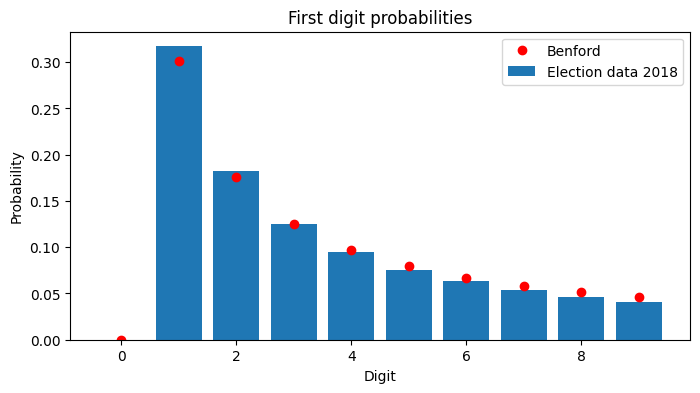

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values(), label='Election data 2018')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


In [34]:
#create a table with this columns: first digit, Benford's probabilities, Election data 2018 probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory


,First digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.301030,0.317100,0.016070
2,2,0.176091,0.182188,0.006096
3,3,0.124939,0.125606,0.000667
4,4,0.096910,0.095354,-0.001556
5,5,0.079181,0.075734,-0.003447
6,6,0.066947,0.063389,-0.003558
7,7,0.057992,0.054091,-0.003901
8,8,0.051153,0.045817,-0.005335
9,9,0.045757,0.040722,-0.005036


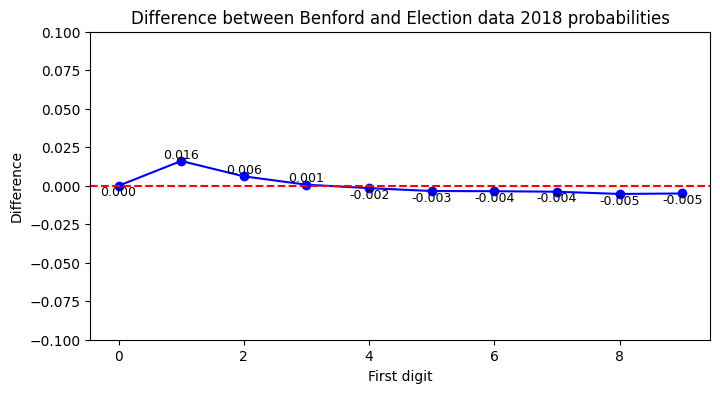

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()


In [36]:
benford_deviation(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1))

1.6069748749152013

#### Some statistical tests

In [106]:
# Define the lists of d_j as digits from 1 to 9
d= [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Define the list of p_j as the probabilities for the first digit
p = list(benford_nth_digit_probabilities_gen(10, 1).values())

print(p)

# Compute the sum
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)


[0, 0.30102999566398114, 0.17609125905568124, 0.1249387366082999, 0.0969100130080564, 0.0791812460476248, 0.06694678963061322, 0.057991946977686726, 0.051152522447381284, 0.04575749056067514]
3.4402369671232056


In [124]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
p=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.0, 0.3170997444131332, 0.18218756143915066, 0.12560619961989644, 0.09535356183236122, 0.07573399305328003, 0.06338881971295629, 0.05409102824562553, 0.04581722262271446, 0.040721869060882106]
3.31038239727374


#### Second digit

We can do the same analysis that we have done for the first digit but for the second digit.

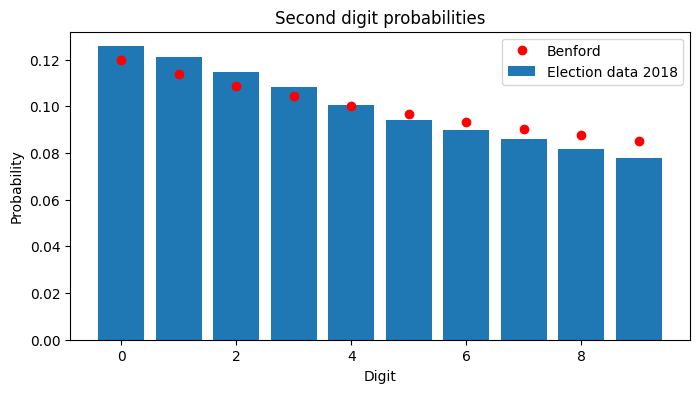

In [92]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ro', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values(), label='Election data 2018')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()


plt.show()


In [93]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(2).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,Second digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.119679,0.125662,0.005983
1,1,0.113890,0.121117,0.007227
2,2,0.108821,0.114664,0.005843
3,3,0.104330,0.108211,0.003881
4,4,0.100308,0.100578,0.000269
5,5,0.096677,0.094325,-0.002352
6,6,0.093375,0.089667,-0.003707
7,7,0.090352,0.086089,-0.004263
8,8,0.087570,0.081758,-0.005812
9,9,0.084997,0.077928,-0.007069


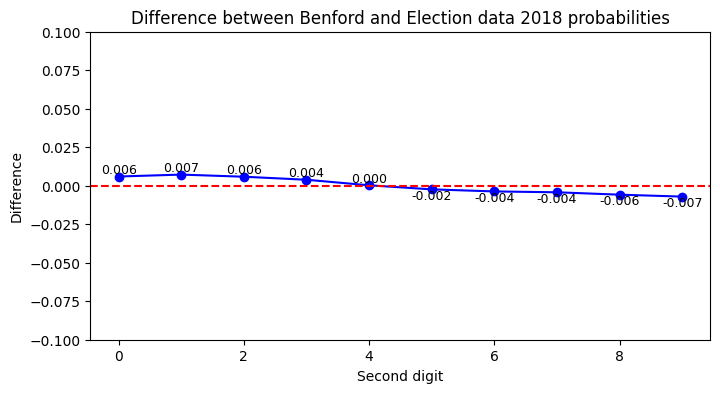

In [94]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['Second digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('Second digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['Second digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()


In [125]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
d= [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
p=list(benford_nth_digit_probabilities_gen(10, 2).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.11967926859688073, 0.1138901034075564, 0.10882149900550823, 0.10432956023095939, 0.10030820226757936, 0.09667723580232242, 0.09337473578303615, 0.09035198926960332, 0.08757005357886136, 0.08499735205769224]
4.1873897069289425


In [126]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
p=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.12566227244193345, 0.1211173885750157, 0.11466415568110483, 0.10821092278719398, 0.1005775266792216, 0.09432517263025737, 0.08966729441305712, 0.08608913998744508, 0.08175768989328311, 0.07792843691148776]
4.045059635907093


### Third digit

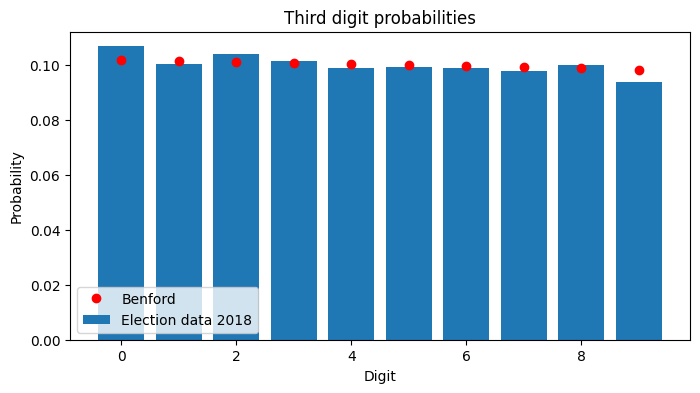

In [40]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(3).keys()), list(benford_nth_digit_probabilities(3).values()), 'ro', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values(), label='Election data 2018')
ax.set_title('Third digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

In [41]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(3).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,Second digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.101784,0.106676,0.004891
1,1,0.101376,0.100199,-0.001177
2,2,0.100972,0.103905,0.002932
3,3,0.100573,0.101289,0.000716
4,4,0.100178,0.098923,-0.001255
5,5,0.099788,0.099016,-0.000772
6,6,0.099401,0.098736,-0.000665
7,7,0.099019,0.097802,-0.001217
8,8,0.098641,0.099794,0.001153
9,9,0.098267,0.093660,-0.004607


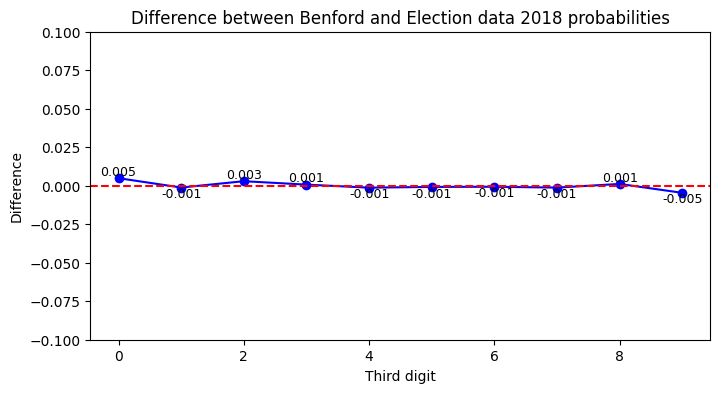

In [42]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['Second digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('Third digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['Second digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()

In [127]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
d= [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
p=list(benford_nth_digit_probabilities_gen(10, 3).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.1017843646442167, 0.10137597744780127, 0.10097219813704164, 0.10057293211092619, 0.1001780876279476, 0.09978757569217742, 0.09940130994496177, 0.09901920656189599, 0.09864118415477718, 0.09826716367825328]
4.46776565097288


In [128]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
p=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.10667580022418732, 0.10019927761863245, 0.10390459584007972, 0.10128907709552872, 0.09892265537426828, 0.09901606675800224, 0.09873583260680036, 0.0978017187694607, 0.09979449495578528, 0.09366048075725496]
4.420973969361067


We know that the Benford's law doesn't work for small numbers, so we can try to remove all the rows that has a number of votanti smaller than 1000.
We are removing 52990 rows of votes coming from small comuni.

In [43]:
#keep only rows with VOTANTI>1000 and voti_lista>0
election_data_18_small = election_data_18[(election_data_18['VOTANTI'] > 1000) & (election_data_18['VOTI_LISTA'] > 0)]
election_18_grouped_small = election_data_18_small.groupby(['COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
election_18_grouped_small

,COMUNE,LISTA,VOTI_LISTA
0,ABANO TERME,+EUROPA,343.0
1,ABANO TERME,10 VOLTE MEGLIO,47.0
2,ABANO TERME,CASAPOUND ITALIA,72.0
3,ABANO TERME,CIVICA POPOLARE LORENZIN,48.0
4,ABANO TERME,FORZA ITALIA,1408.0
...,...,...,...
80252,ZUNGRI,PARTITO COMUNISTA,2.0
80253,ZUNGRI,PARTITO DEMOCRATICO,165.0
80254,ZUNGRI,PARTITO VALORE UMANO,1.0
80255,ZUNGRI,PER UNA SINISTRA RIVOLUZIONARIA,1.0


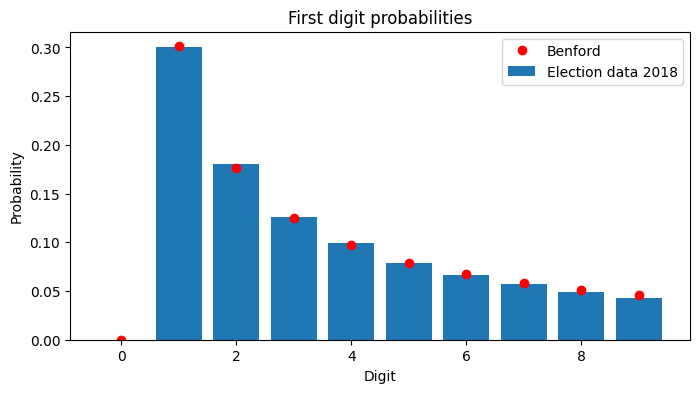

In [44]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).keys(), data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).values(), label='Election data 2018')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

In [45]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.301030,0.300871,-0.000159
2,2,0.176091,0.180333,0.004242
3,3,0.124939,0.126132,0.001194
4,4,0.096910,0.098783,0.001873
5,5,0.079181,0.078311,-0.000870
6,6,0.066947,0.066623,-0.000323
7,7,0.057992,0.057191,-0.000801
8,8,0.051153,0.048694,-0.002459
9,9,0.045757,0.043062,-0.002696


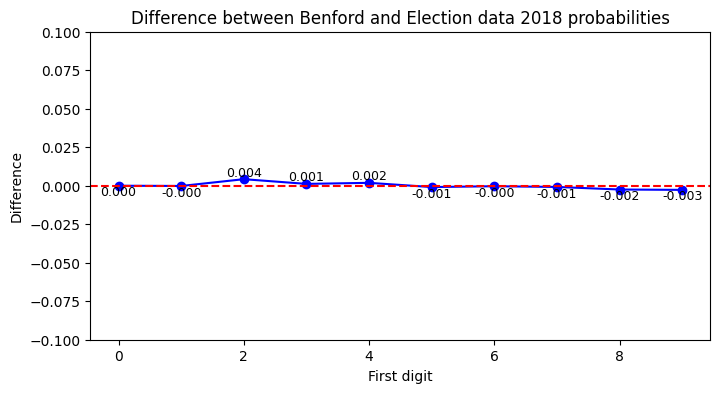

In [46]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()


Now we want to implement a chi-square test to see if the distribution of the first digit is different from the Benford's law. In order to do this, we remove the rows with zero votes and we multiply the frequincies for the numbers of comuni that we have in the dataset.

In [ ]:
#chi-squared test without zeros
benford_chi2 = [value for value in list(benford_nth_digit_probabilities(1).values()) if value != 0]
election_18_chi2 = [value for value in data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values() if value != 0]


#in order to do a chi-squared test, I have to transform my data because I have proportions and not numbers. So I have to multiply them by the total number of voti_lista
total_votes = election_18_grouped['VOTI_LISTA'].shape[0]

In [50]:
import numpy as np
from scipy.stats import chisquare


# Calculate observed and expected frequencies
observed_frequencies = election_18_chi2 * total_votes
expected_frequencies = benford_chi2 * total_votes


#h0 hypothesis that data are not been fraudolent and so the distribution is the same as Benford's Law
#h1 hypothesis that data are been fraudolent and so the distribution is different from Benford's Law
chi2, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)

print("Chi-squared statistic:", chi2)
print("p-value:", p_value)

if p_value < 0.05:
    print("We reject the null hypothesis H0: Data can be corrupted (the distribution is statistically different from the Benford\'s law).")
else:
    print("We cannot reject H0: the distribution is not statistically different from the Benford\'s law.")

Chi-squared statistic: 342.9844319736383
p-value: 1.0
We cannot reject H0: the distribution is not statistically different from the Benford's law.


We perform a chi-square test using the dataset in which we have removed small comuni. The null hypothesis is again that the distribution of the first digit is the same as the Benford's law

In [52]:
benford_chi2 = [value for value in list(benford_nth_digit_probabilities(1).values()) if value != 0]
election_18_chi2 = [value for value in data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).values() if value != 0]
total_votes = election_18_grouped_small['VOTI_LISTA'].shape[0]

observed_frequencies = election_18_chi2 * total_votes
expected_frequencies = benford_chi2 * total_votes


#h0 hypothesis that data are not been fraudolent and so the distribution is the same as Benford's Law
#h1 hypothesis that data are been fraudolent and so the distribution is different from Benford's Law
chi2, p_value = chisquare(observed_frequencies, f_exp=expected_frequencies)

print("Chi-squared statistic:", chi2)
print("p-value:", p_value)

if p_value < 0.05:
    print("We reject the null hypothesis H0: Data can be corrupted (the distribution is statistically different from the Benford\'s law).")
else:
    print("We cannot reject H0: the distribution is not statistically different from the Benford\'s law.")

Chi-squared statistic: 36.041003489009526
p-value: 1.0
We cannot reject H0: the distribution is not statistically different from the Benford's law.


#Brexit referendum

In [53]:
#read the csv data of the brexit referendum
file_path = "C:/Users/franc/Desktop/Tesi/Benford/Codice/Dati/EU-referendum-result-data.csv"
brexit_data = pd.read_csv(file_path)
brexit_data
#show me the name of the variables
brexit_data.columns



Index(['id', 'Region_Code', 'Region', 'Area_Code', 'Area', 'Electorate',
       'ExpectedBallots', 'VerifiedBallotPapers', 'Pct_Turnout', 'Votes_Cast',
       'Valid_Votes', 'Remain', 'Leave', 'Rejected_Ballots',
       'No_official_mark', 'Voting_for_both_answers', 'Writing_or_mark',
       'Unmarked_or_void', 'Pct_Remain', 'Pct_Leave', 'Pct_Rejected'],
      dtype='object')

In [54]:
#keep only the columns with area, expectedballots, remain, leave
brexit_data = brexit_data[['Area', 'Remain', 'Leave', 'Valid_Votes']]
brexit_data

,Area,Remain,Leave,Valid_Votes
0,Peterborough,34176,53216,87392
1,Luton,36708,47773,84481
2,Southend-on-Sea,39348,54522,93870
3,Thurrock,22151,57765,79916
4,Bedford,41497,44569,86066
...,...,...,...,...
377,Bradford,104575,123913,228488
378,Calderdale,46950,58975,105925
379,Kirklees,98485,118755,217240
380,Leeds,194863,192474,387337


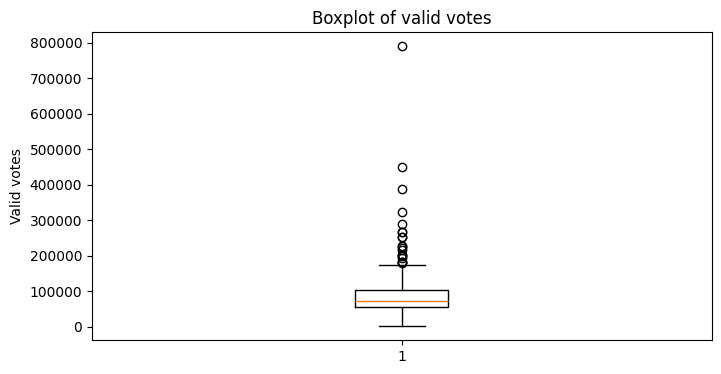

In [55]:
#plot a boxplot of the valid votes
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(brexit_data['Valid_Votes'])
ax.set_title('Boxplot of valid votes')
ax.set_ylabel('Valid votes')
plt.show()



In [56]:
#remove the outliers from the valid votes, that are the values greater than 1.5 times the interquartile range
Q1 = brexit_data['Valid_Votes'].quantile(0.25)
Q3 = brexit_data['Valid_Votes'].quantile(0.75)
IQR = Q3 - Q1
brexit_data_no_outliers = brexit_data[(brexit_data['Valid_Votes'] >= Q1 - 1.5 * IQR) & (brexit_data['Valid_Votes'] <= Q3 + 1.5 * IQR)]
brexit_data_no_outliers


,Area,Remain,Leave,Valid_Votes
0,Peterborough,34176,53216,87392
1,Luton,36708,47773,84481
2,Southend-on-Sea,39348,54522,93870
3,Thurrock,22151,57765,79916
4,Bedford,41497,44569,86066
...,...,...,...,...
373,Barnsley,38951,83958,122909
374,Doncaster,46922,104260,151182
375,Rotherham,44115,93272,137387
378,Calderdale,46950,58975,105925


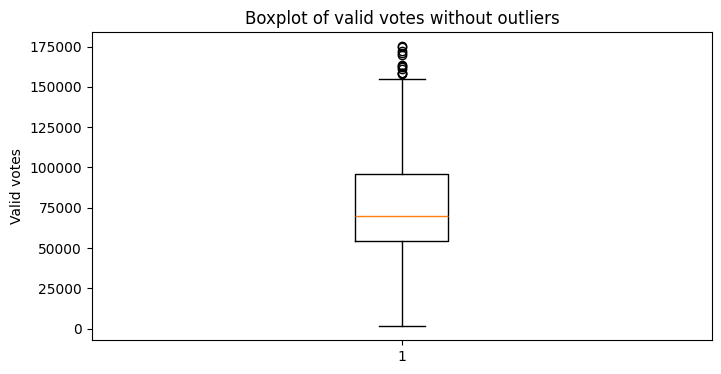

In [57]:
#do another boxplot of the valid votes
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(brexit_data_no_outliers['Valid_Votes'])
ax.set_title('Boxplot of valid votes without outliers')
ax.set_ylabel('Valid votes')
plt.show()


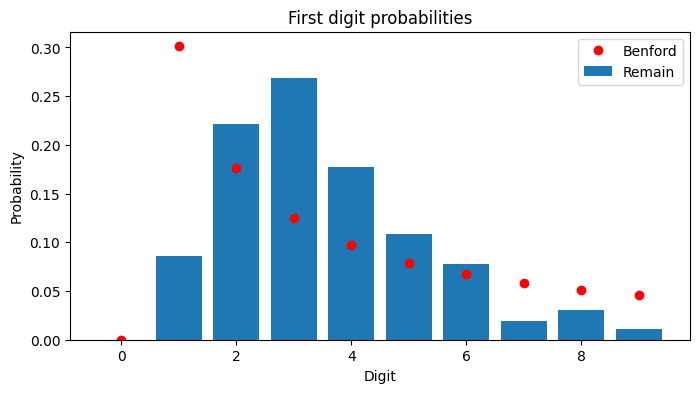

In [58]:
#apply the benford's law to the remain column
remain_benford = data_digit_probabilities(brexit_data_no_outliers['Leave'], 1)
remain_benford

#plot the remain_benford
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(remain_benford.keys(), remain_benford.values(), label='Remain')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


In [59]:
remain_benford

{0: 0.0,
 1: 0.08587257617728532,
 2: 0.22160664819944598,
 3: 0.26869806094182824,
 4: 0.1772853185595568,
 5: 0.10803324099722991,
 6: 0.07756232686980609,
 7: 0.019390581717451522,
 8: 0.030470914127423823,
 9: 0.0110803324099723}

In [60]:
#multiply all the rows of remain_benford by total_votes
obs_freq = [value * total_votes for value in remain_benford.values()]
obs_freq

[0.0,
 6891.875346260388,
 17785.484764542936,
 21564.90027700831,
 14228.38781163435,
 8670.423822714682,
 6224.9196675900275,
 1556.2299168975069,
 2445.5041551246536,
 889.2742382271468]

In [ ]:
#chi-squared test


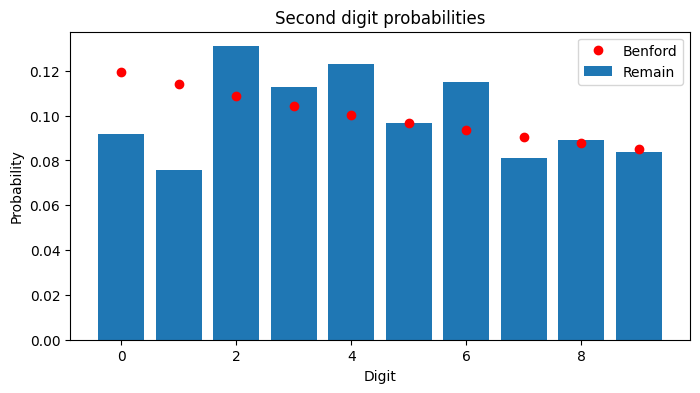

In [62]:
#do the same for the second digit
remain_benford = data_digit_probabilities(brexit_data['Remain'], 2)
remain_benford

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ro', label='Benford')
ax.bar(remain_benford.keys(), remain_benford.values(), label='Remain')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()
